In [3]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [4]:
data_path = os.path.join(os.environ['HOME'],
                         'fits/uoineuro/tuning/ret1/')

# Plot Example STRF

In [5]:
ret1 = '20080628_R4'

In [6]:
results = h5py.File(data_path + ret1 + '.h5', 'r')

In [7]:
cell = 2
recording = 0
cell_recording = results['cell' + str(cell) + '_recording' + str(recording)]

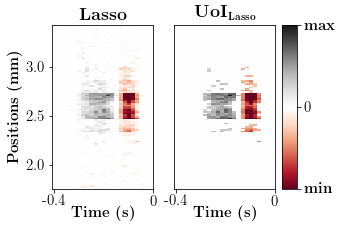

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(4, 3))

lasso_strf = np.flip(cell_recording['lasso/strfs'][:].T,
                     axis=(0, 1))
uoi_strf = np.flip(cell_recording['uoi_lasso_bic/strfs'][:].T,
                   axis=(0, 1))

axes[0].imshow(
    lasso_strf,
    cmap=plt.get_cmap('RdGy'),
    vmin=-1e-06, vmax=1e-06)

img = axes[1].imshow(
    uoi_strf,
    cmap=plt.get_cmap('RdGy'),
    vmin=-1e-06, vmax=1e-06)

# create colorbar
ax_bottom_right_x, ax_bottom_right_y = fig.transFigure.inverted().transform(axes[1].transAxes.transform([1.0, 0.]))
ax_top_right_x, ax_top_right_y = fig.transFigure.inverted().transform(axes[1].transAxes.transform([1.0, 1.0]))
cax = fig.add_axes([ax_bottom_right_x + 0.025, ax_bottom_right_y,
                    0.05, ax_top_right_y - ax_bottom_right_y])
cb = fig.colorbar(img, cax)
cb.set_ticks([-1e-06, 0, 1e-06])
cb.set_ticklabels([r'\textbf{min}', 0, r'\textbf{max}'])
cb.ax.tick_params(labelsize=15)

# titles
axes[0].set_title(r'\textbf{Lasso}', fontsize=18)
axes[1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$', fontsize=18)
axes[0].set_ylabel(r'\textbf{Positions (mm)}', fontsize=15)

# set y ticks
axes[0].set_yticks([320 * (5.312 - 3) / (5.312 - 0.0083),
                    320 * (5.312 - 2.5) / (5.312 - 0.0083),
                    320 * (5.312 - 2) / (5.312 - 0.0083)])
axes[0].set_yticklabels([2.0, 2.5, 3.0])
axes[1].set_yticks([])

for ax in axes:
    ax.set_aspect('auto')
    ax.set_xticks([0, 24])
    ax.set_xticklabels(['-0.4', '0'])
    ax.set_ylim([125, 225])
    ax.tick_params(labelsize=15)
    ax.set_xlabel(r'\textbf{Time (s)}', fontsize=15, labelpad=-3)
    
plt.savefig('ret1_example_strf.pdf', bbox_inches='tight')

In [7]:
results.close()

# Consolidate Selection Ratios and Predictive Performance

In [9]:
retinas = {
    '20080516_R1': ['cell0_recording0',
                    'cell0_recording2',
                    'cell2_recording0',
                    'cell3_recording0',
                    'cell4_recording0',
                    'cell5_recording0'],
    '20080628_R4': ['cell0_recording0',
                    'cell2_recording0',
                    'cell3_recording0',
                    'cell5_recording0',
                    'cell6_recording0',
                    'cell7_recording0',
                    'cell9_recording0',
                    'cell12_recording0',
                    'cell13_recording0'],
    '20080628_R6': ['cell1_recording0',
                    'cell2_recording0',
                    'cell4_recording0',
                    'cell5_recording0',
                    'cell6_recording0',
                    'cell7_recording0',
                    'cell8_recording0',
                    'cell10_recording0']
}

In [10]:
lasso_sr = []
uoi_sr = []
lasso_r2 = []
uoi_r2 = []
lasso_bic = []
uoi_bic = []

# iterate over retina files
for retina, recordings in retinas.items():
    results = h5py.File(data_path + retina + '.h5', 'r')
    # iterate over recordings
    for cell_recording in recordings:
        # calculate selection ratios
        lasso_strf = results[cell_recording]['lasso/strfs'][:]
        lasso_sr.append(np.count_nonzero(lasso_strf) / lasso_strf.size)
        uoi_strf = results[cell_recording]['uoi_lasso_bic/strfs'][:]
        uoi_sr.append(np.count_nonzero(uoi_strf) / uoi_strf.size)

        # extract predictive performance
        lasso_r2.append(results[cell_recording]['lasso/r2s_test'][:].max())
        uoi_r2.append(results[cell_recording]['uoi_lasso_bic/r2s_test'][:].max())

        # extract model parsimony
        lasso_bic.append(results[cell_recording]['lasso/bics'][:].min())
        uoi_bic.append(results[cell_recording]['uoi_lasso_bic/bics'][:].min())

    results.close()

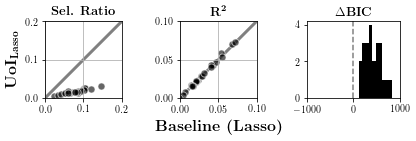

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

# plot selection ratios
axes[0].scatter(lasso_sr, uoi_sr,
                s=50,
                alpha=0.6,
                color='k',
                edgecolor='white')
axes[0].set_xlim([0, 0.2])
axes[0].set_xticks([0, 0.1, 0.2])
axes[0].set_title(r'\textbf{Sel. Ratio}', fontsize=13)

# plot r2 values
axes[1].scatter(lasso_r2, uoi_r2,
                s=50,
                alpha=0.6,
                color='k',
                edgecolor='white')
axes[1].set_xlim([0, 0.1])
axes[1].set_xticks([0, 0.05, 0.1])
axes[1].set_title(r'$\mathbf{R^2}$', fontsize=13)

# histogram of del BICs
axes[2].hist(np.array(lasso_bic) - np.array(uoi_bic),
             color='black')
axes[2].set_xlim([-1000, 1000])
axes[2].axvline(0, color='gray', linestyle='--')
axes[2].tick_params(labelsize=10)
axes[2].set_title(r'$\Delta$\textbf{BIC}', fontsize=13)

for ax in axes[:2]:
    ax.set_ylim(ax.get_xlim())
    ax.set_aspect('equal')
    ax.plot(ax.get_xlim(), ax.get_ylim(),
            color='gray',
            linewidth=3,
            zorder=-1)
    ax.tick_params(labelsize=10)
    ax.set_yticks(ax.get_xticks())
    ax.grid('on')

axes[0].set_ylabel(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$', fontsize=16)
axes[1].set_xlabel(r'\textbf{Baseline (Lasso)}', fontsize=16)

plt.tight_layout()
plt.savefig('ret1_metric_summary.pdf', bbox_inches='tight')